# Advanced Machine Learning - programming assignment 1

**Please fill in:**
* Davide Schiavi (6967620)
* Samuel Meyer (5648122)
* Riccardo Bassani (6866840)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt

# Generate data from the observational distribution
def f_Z(num_samples):
    # generates 'num_samples' random numbers between 0 and 8
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    # X is directly proportional to z, plus a random number
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    # X is directly proportional to z, inversely proportional to x, plus a random number
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

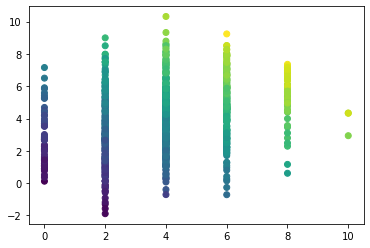

In [2]:
plt.scatter(x, y, c=z)
plt.show()

With any supervised learning method of your choice, predict y using x as the only feature. Make a new plot that displays both the data and your prediction curve.

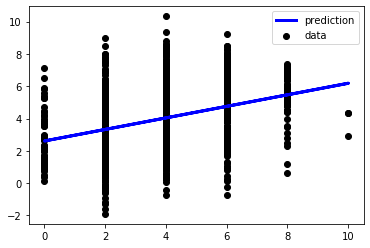

In [3]:
# Create linear regression object.
# The split parameter is always False through the assignment, in order to allow the predictions to range over the full spectrum of the data.
def plot_linear_regression(x,y, ratio=0.8, split=False, weight=False, weights=[]):
        
    x = x.reshape(len(x), 1)
    y = y.reshape(len(y), 1)
    
    regr = linear_model.LinearRegression()
    
    if split:
        threshold = int(x.size*ratio)
        # Split the data into training/testing sets
        X_train = x[:-threshold]
        X_test = x[-threshold:]
        # Split the targets into training/testing sets
        Y_train = y[:-threshold]
        Y_test = y[-threshold:]

    else:
        X_train = x
        X_test = x
        Y_train = y
        Y_test = y
        
    # Train the model using the training set
    if (weight):
        regr.fit(X_train, Y_train, sample_weight=weights)
    else:
        regr.fit(X_train, Y_train)
        

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # Plot outputs
    plt.scatter(X_test, Y_test,  color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.legend(("prediction", "data"), loc="best")

    plt.show()
    
    return (y_pred, Y_test)

(y_pred, Y_test) = plot_linear_regression(x,y)

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug. Complete the following function.

In [4]:
def generate_experimental_data(x, num_samples):
    z = f_Z(num_samples)
    x = x
    y = f_Y(z, x, num_samples)
    return (x, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set {0,2,4,8}, independently for each individual.

In [5]:
num_samples_exp = 200

x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

Plot these experimental data in the same way as before, again with your prediction curve in the same plot.

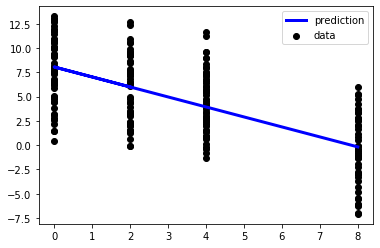

In [6]:
(y_pred, Y_test) = plot_linear_regression(x_exp, y_exp)


Compute the RMSE (root mean squared error) when you use the predictor you learned earlier to predict y in these new data.

In [7]:
err_1 = np.sqrt(((Y_test - y_pred) ** 2).mean())
print("RMSE: ", err_1)

RMSE:  3.4368146110104925


**Question:** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

Based on d-separation, X and Z are marginally independent.

This happens because the informaton of a variable does not reach the other variable through the collider Z --> Y <-- X.

The plot illustrates that the predicted value of Z (i.e. 4) is the same for all values of X (0,2,4,8). This shows that X and Z are marginally independent.

This can be contrasted with the previous plot in which x and y are shown to be dependent.

X and Z are likely dependent given Y.

X and Y are likely dependent.

Z and Y are likely dependent.

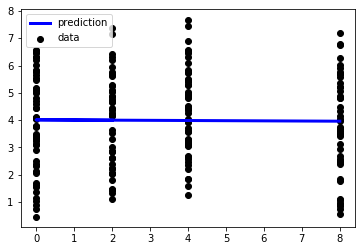

In [8]:
(z_pred, Z_test) = plot_linear_regression(x_exp, z_exp)

Now, we will use the method of Inverse Probability Weighing (section 3.6 in the book) for this task. Using *only the observational data*, fit a logistic regression to predict x using z as a feature. From this logistic regression, extract estimates for $P(X=x|Z=z)$. Use these to compute an inverse probability weight for each data point in the observational data set.

In [9]:
# Create logistic regression object
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

x = x.reshape(len(x), 1)
z = z.reshape(len(z), 1)
reg_logistic.fit(z, x.ravel())

x_pred = reg_logistic.predict_proba(z)

weights = list()
for i, point in enumerate(x):
    weights.append(1/x_pred[i][point//2])
weights = np.array(weights)
weights = weights.reshape(1000)

Now again predict y in terms of x using only the observational data as training data, but this time weight each data point with the inverse probability weight. Plot your regression curve in the same plot as the experimental data, as before.

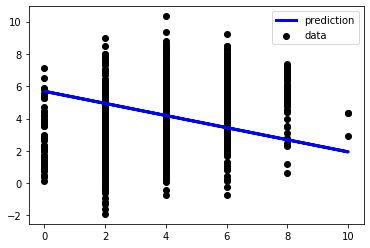

In [10]:
(y_pred, y_test) = plot_linear_regression(x, y, weight=True, weights=weights)

To verify that these predictions of the causal effect of X on Y are more accurate, again compute the RMSE on the experimental data.

In [11]:
err_2 = np.sqrt(((y_test - y_pred) ** 2).mean())
print ("RMSE: ", err_2, "\n")

diff = err_1 - err_2

print("The RMSE decreased by ", diff)


RMSE:  2.4413624112747496 

The RMSE decreased by  0.9954521997357428


You are done! Before handing in, use Kernel > Restart & run all. This makes sure that the code you hand in works, and that all plots are shown. Submit just one file per team.